<div style="background-color: #f4f4f9; padding: 12px; border-radius: 6px; border: 1px solid #c8c8c8;">
    <strong style="color: #333333;">Note:</strong> <span style="color: #555555;">After downloading dependencies, restart the session.</span>
</div>


In [ ]:
!pip install -q node2vec networkx annoy

In [ ]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

## Explore the features of the nodes
Load and process the feature data (`.feat` and `.featnames` files).

In [ ]:
!wget http://snap.stanford.edu/data/facebook.tar.gz
!tar -xvf "facebook.tar.gz"

In [ ]:
folder = "facebook"
feature_data = {}

for file in os.listdir(folder):
    if file.endswith(".feat"):
        base_filename = file.replace(".feat", "")
        feat_path = os.path.join(folder, file)
        featnames_path = os.path.join(folder, f"{base_filename}.featnames")

        if os.path.exists(featnames_path):
            with open(featnames_path, 'r') as f:
                feature_names = [line.strip() for line in f]
            df_features = pd.read_csv(feat_path, sep=" ", header=None)

            # The first column of the .feat file is the node ID
            # The remaining columns are the feature values
            node_ids_feat = df_features.iloc[:, 0].astype(int)
            feature_values = df_features.iloc[:, 1:]

            # Assign column names. The number of feature names should match the number of feature columns.
            # Adjust feature names to prepend 'feature_value;' to distinguish them
            adjusted_feature_names = [f"feature_value;{name}" for name in feature_names]

            # Check if the number of feature columns matches the number of feature names
            if len(adjusted_feature_names) == feature_values.shape[1]:
                 feature_values.columns = adjusted_feature_names
            else:
                 # Handle cases where the number of feature names doesn't match (e.g., some features are multi-valued)
                 # A common pattern is 'feature_name;value' or just 'feature_name' for binary features
                 # For simplicity here, if they don't match, we'll use generic names, but print a warning
                 print(f"Warning: Number of feature names ({len(adjusted_feature_names)}) does not match number of feature columns ({feature_values.shape[1]}) for {base_filename}. Using generic column names.")
                 feature_values.columns = [f'feature_{i}' for i in range(feature_values.shape[1])]


            # Combine node IDs and features into a single DataFrame
            df_features.columns = ['node_id'] + list(feature_values.columns)
            df_features['node_id'] = node_ids_feat # Ensure node_id is correctly assigned

            # Store in the dictionary
            feature_data[base_filename] = {
                'feature_names': feature_names,
                'dataframe': df_features
            }
        else:
            print(f"Warning: .featnames file not found for {file}")

print(f"Loaded feature data for {len(feature_data)} graphs.")
for graph_name, data in feature_data.items():
    print(f"Graph: {graph_name}, Nodes with features: {data['dataframe'].shape[0]}, Total features: {data['dataframe'].shape[1] - 1}") # Subtract 1 for node_id
    display(data['dataframe'].head())

Loaded feature data for 10 graphs.
Graph: 3980, Nodes with features: 59, Total features: 42


,node_id,feature_value;0 birthday;anonymized feature 6,feature_value;1 education;concentration;id;anonymized feature 14,feature_value;2 education;degree;id;anonymized feature 22,feature_value;3 education;school;id;anonymized feature 50,feature_value;4 education;school;id;anonymized feature 52,feature_value;5 education;type;anonymized feature 53,feature_value;6 education;type;anonymized feature 54,feature_value;7 education;type;anonymized feature 55,feature_value;8 education;year;id;anonymized feature 542,...,feature_value;32 work;employer;id;anonymized feature 1279,feature_value;33 work;employer;id;anonymized feature 1280,feature_value;34 work;employer;id;anonymized feature 52,feature_value;35 work;employer;id;anonymized feature 154,feature_value;36 work;employer;id;anonymized feature 156,feature_value;37 work;end_date;anonymized feature 157,feature_value;38 work;start_date;anonymized feature 157,feature_value;39 work;start_date;anonymized feature 1281,feature_value;40 work;start_date;anonymized feature 718,feature_value;41 work;start_date;anonymized feature 1282
0,3981,0,1,0,0,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,3982,0,0,0,0,0,1,1,1,0,...,1,1,0,0,0,0,0,1,0,0
2,3983,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3984,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3985,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0


Graph: 3437, Nodes with features: 547, Total features: 262


,node_id,feature_value;0 birthday;anonymized feature 1172,feature_value;1 birthday;anonymized feature 208,feature_value;2 birthday;anonymized feature 0,feature_value;3 birthday;anonymized feature 1,feature_value;4 birthday;anonymized feature 209,feature_value;5 birthday;anonymized feature 2,feature_value;6 birthday;anonymized feature 3,feature_value;7 birthday;anonymized feature 6,feature_value;8 education;concentration;id;anonymized feature 1173,...,feature_value;252 work;start_date;anonymized feature 1269,feature_value;253 work;start_date;anonymized feature 375,feature_value;254 work;start_date;anonymized feature 675,feature_value;255 work;start_date;anonymized feature 310,feature_value;256 work;start_date;anonymized feature 158,feature_value;257 work;start_date;anonymized feature 162,feature_value;258 work;start_date;anonymized feature 723,feature_value;259 work;start_date;anonymized feature 198,feature_value;260 work;start_date;anonymized feature 199,feature_value;261 work;start_date;anonymized feature 725
0,3438,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3439,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3440,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3441,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3442,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Graph: 348, Nodes with features: 227, Total features: 161


,node_id,feature_value;0 birthday;anonymized feature 206,feature_value;1 birthday;anonymized feature 207,feature_value;2 birthday;anonymized feature 208,feature_value;3 birthday;anonymized feature 0,feature_value;4 birthday;anonymized feature 1,feature_value;5 birthday;anonymized feature 209,feature_value;6 birthday;anonymized feature 2,feature_value;7 birthday;anonymized feature 3,feature_value;8 birthday;anonymized feature 210,...,feature_value;151 work;position;id;anonymized feature 192,feature_value;152 work;position;id;anonymized feature 193,feature_value;153 work;start_date;anonymized feature 157,feature_value;154 work;start_date;anonymized feature 305,feature_value;155 work;start_date;anonymized feature 306,feature_value;156 work;start_date;anonymized feature 307,feature_value;157 work;start_date;anonymized feature 308,feature_value;158 work;start_date;anonymized feature 309,feature_value;159 work;start_date;anonymized feature 310,feature_value;160 work;start_date;anonymized feature 202
0,349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,350,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,351,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,352,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,353,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Graph: 1684, Nodes with features: 792, Total features: 319


,node_id,feature_value;0 birthday;anonymized feature 1003,feature_value;1 birthday;anonymized feature 1004,feature_value;2 birthday;anonymized feature 210,feature_value;3 birthday;anonymized feature 4,feature_value;4 birthday;anonymized feature 5,feature_value;5 birthday;anonymized feature 6,feature_value;6 birthday;anonymized feature 7,feature_value;7 birthday;anonymized feature 377,feature_value;8 birthday;anonymized feature 378,...,feature_value;309 work;start_date;anonymized feature 160,feature_value;310 work;start_date;anonymized feature 197,feature_value;311 work;start_date;anonymized feature 164,feature_value;312 work;start_date;anonymized feature 199,feature_value;313 work;start_date;anonymized feature 166,feature_value;314 work;start_date;anonymized feature 201,feature_value;315 work;start_date;anonymized feature 168,feature_value;316 work;start_date;anonymized feature 202,feature_value;317 work;start_date;anonymized feature 169,feature_value;318 work;start_date;anonymized feature 170
0,2661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2662,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2663,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2664,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2665,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Graph: 698, Nodes with features: 66, Total features: 48


,node_id,feature_value;0 birthday;anonymized feature 2,feature_value;1 birthday;anonymized feature 3,feature_value;2 education;classes;id;anonymized feature 335,feature_value;3 education;classes;id;anonymized feature 336,feature_value;4 education;concentration;id;anonymized feature 14,feature_value;5 education;degree;id;anonymized feature 22,feature_value;6 education;school;id;anonymized feature 340,feature_value;7 education;school;id;anonymized feature 341,feature_value;8 education;school;id;anonymized feature 369,...,feature_value;38 work;employer;id;anonymized feature 373,feature_value;39 work;employer;id;anonymized feature 140,feature_value;40 work;employer;id;anonymized feature 154,feature_value;41 work;end_date;anonymized feature 157,feature_value;42 work;end_date;anonymized feature 161,feature_value;43 work;location;id;anonymized feature 374,feature_value;44 work;location;id;anonymized feature 366,feature_value;45 work;start_date;anonymized feature 157,feature_value;46 work;start_date;anonymized feature 375,feature_value;47 work;start_date;anonymized feature 196
0,810,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,857,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,811,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,858,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,859,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Graph: 414, Nodes with features: 159, Total features: 105


,node_id,feature_value;0 birthday;anonymized feature 208,feature_value;1 birthday;anonymized feature 0,feature_value;2 birthday;anonymized feature 1,feature_value;3 birthday;anonymized feature 209,feature_value;4 birthday;anonymized feature 2,feature_value;5 birthday;anonymized feature 3,feature_value;6 birthday;anonymized feature 211,feature_value;7 education;concentration;id;anonymized feature 14,feature_value;8 education;concentration;id;anonymized feature 15,...,feature_value;95 work;location;id;anonymized feature 84,feature_value;96 work;location;id;anonymized feature 297,feature_value;97 work;position;id;anonymized feature 183,feature_value;98 work;position;id;anonymized feature 301,feature_value;99 work;position;id;anonymized feature 333,feature_value;100 work;start_date;anonymized feature 157,feature_value;101 work;start_date;anonymized feature 334,feature_value;102 work;start_date;anonymized feature 310,feature_value;103 work;start_date;anonymized feature 200,feature_value;104 work;start_date;anonymized feature 202
0,573,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,574,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,576,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,577,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Graph: 686, Nodes with features: 170, Total features: 63


,node_id,feature_value;0 birthday;anonymized feature 209,feature_value;1 birthday;anonymized feature 2,feature_value;2 birthday;anonymized feature 3,feature_value;3 birthday;anonymized feature 210,feature_value;4 education;classes;id;anonymized feature 335,feature_value;5 education;classes;id;anonymized feature 336,feature_value;6 education;concentration;id;anonymized feature 14,feature_value;7 education;concentration;id;anonymized feature 337,feature_value;8 education;concentration;id;anonymized feature 338,...,feature_value;53 locale;anonymized feature 126,feature_value;54 locale;anonymized feature 127,feature_value;55 location;id;anonymized feature 359,feature_value;56 location;id;anonymized feature 366,feature_value;57 location;id;anonymized feature 367,feature_value;58 work;employer;id;anonymized feature 343,feature_value;59 work;employer;id;anonymized feature 368,feature_value;60 work;end_date;anonymized feature 157,feature_value;61 work;location;id;anonymized feature 359,feature_value;62 work;start_date;anonymized feature 157
0,687,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,688,0,0,1,0,0,1,0,0,1,...,1,0,1,0,0,0,0,0,1,0
2,689,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,690,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,691,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Graph: 1912, Nodes with features: 755, Total features: 480


,node_id,feature_value;0 birthday;anonymized feature 729,feature_value;1 birthday;anonymized feature 730,feature_value;2 birthday;anonymized feature 731,feature_value;3 birthday;anonymized feature 732,feature_value;4 birthday;anonymized feature 1,feature_value;5 birthday;anonymized feature 2,feature_value;6 birthday;anonymized feature 210,feature_value;7 birthday;anonymized feature 4,feature_value;8 birthday;anonymized feature 5,...,feature_value;470 work;start_date;anonymized feature 725,feature_value;471 work;start_date;anonymized feature 201,feature_value;472 work;start_date;anonymized feature 332,feature_value;473 work;start_date;anonymized feature 726,feature_value;474 work;start_date;anonymized feature 680,feature_value;475 work;start_date;anonymized feature 168,feature_value;476 work;start_date;anonymized feature 202,feature_value;477 work;start_date;anonymized feature 169,feature_value;478 work;start_date;anonymized feature 170,feature_value;479 work;start_date;anonymized feature 681
0,1913,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,1914,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1915,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1916,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1917,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Graph: 0, Nodes with features: 347, Total features: 224


,node_id,feature_value;0 birthday;anonymized feature 0,feature_value;1 birthday;anonymized feature 1,feature_value;2 birthday;anonymized feature 2,feature_value;3 birthday;anonymized feature 3,feature_value;4 birthday;anonymized feature 4,feature_value;5 birthday;anonymized feature 5,feature_value;6 birthday;anonymized feature 6,feature_value;7 birthday;anonymized feature 7,feature_value;8 education;classes;id;anonymized feature 8,...,feature_value;214 work;start_date;anonymized feature 200,feature_value;215 work;start_date;anonymized feature 201,feature_value;216 work;start_date;anonymized feature 168,feature_value;217 work;start_date;anonymized feature 202,feature_value;218 work;start_date;anonymized feature 169,feature_value;219 work;start_date;anonymized feature 170,feature_value;220 work;start_date;anonymized feature 171,feature_value;221 work;start_date;anonymized feature 203,feature_value;222 work;start_date;anonymized feature 204,feature_value;223 work;with;id;anonymized feature 205
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Graph: 107, Nodes with features: 1045, Total features: 576


,node_id,feature_value;0 birthday;anonymized feature 376,feature_value;1 birthday;anonymized feature 0,feature_value;2 birthday;anonymized feature 1,feature_value;3 birthday;anonymized feature 209,feature_value;4 birthday;anonymized feature 2,feature_value;5 birthday;anonymized feature 3,feature_value;6 birthday;anonymized feature 210,feature_value;7 birthday;anonymized feature 4,feature_value;8 birthday;anonymized feature 5,...,feature_value;566 work;start_date;anonymized feature 168,feature_value;567 work;start_date;anonymized feature 202,feature_value;568 work;start_date;anonymized feature 169,feature_value;569 work;start_date;anonymized feature 170,feature_value;570 work;start_date;anonymized feature 171,feature_value;571 work;start_date;anonymized feature 681,feature_value;572 work;start_date;anonymized feature 203,feature_value;573 work;with;id;anonymized feature 727,feature_value;574 work;with;id;anonymized feature 728,feature_value;575 work;with;id;anonymized feature 683
0,896,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,897,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,898,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,899,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,900,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
folder = "facebook"
edges_list = []

for file in os.listdir(folder):
    if file.endswith(".edges"):
        path = os.path.join(folder, file)
        df_edges = pd.read_csv(path, sep=" ", header=None, names=["userFromId", "userToId"])
        edges_list.append(df_edges)

df = pd.concat(edges_list, ignore_index=True)
df.userFromId = df.userFromId.astype(int)
df.userToId = df.userToId.astype(int)

# Optional: cut to avoid memory issues
df = df.iloc[:20000, :].reset_index(drop=True)

Graph with 1546 nodes and 14227 edges


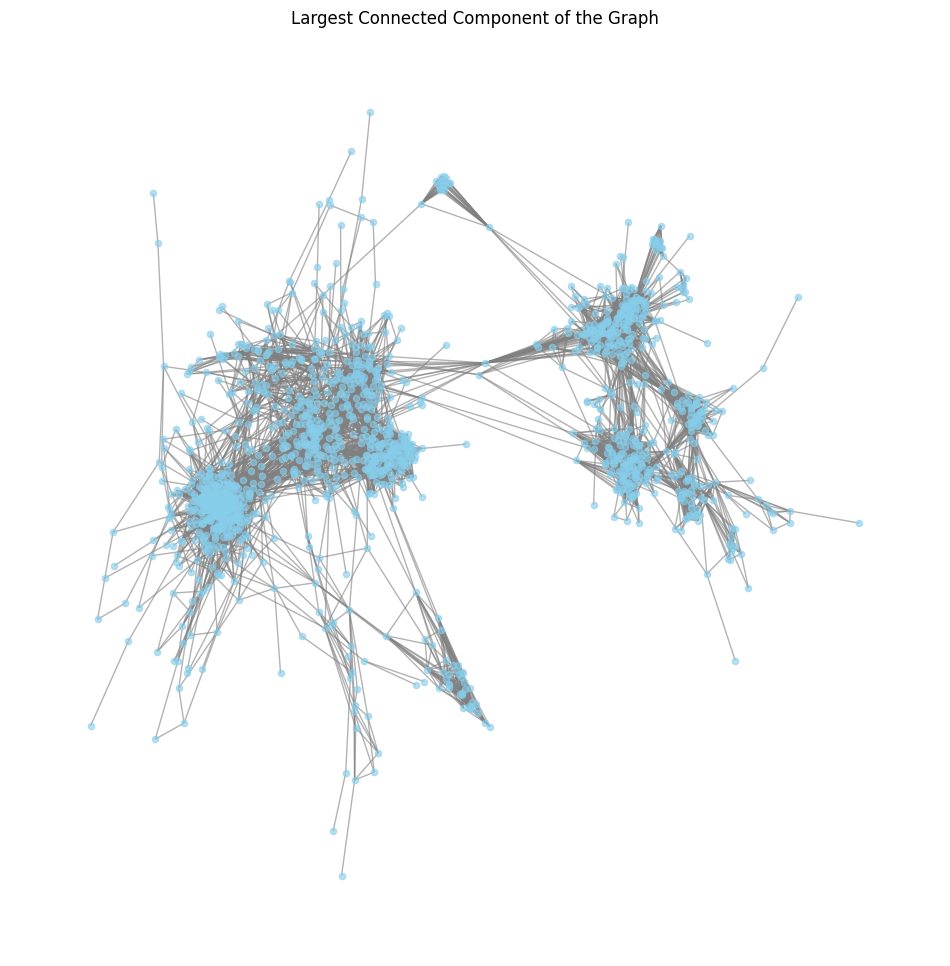

In [ ]:
# =========================
# Build NetworkX Graph
# =========================
G = nx.Graph()
G.add_edges_from(zip(df['userFromId'], df['userToId']))
print(G)

# Visualize the largest connected component
if G.number_of_nodes() > 0:
    largest_component = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_component)

    # Optional: reduce size for faster plotting if LCC is still very large
    # if G_lcc.number_of_nodes() > 500:
    #     G_lcc = G_lcc.subgraph(list(G_lcc.nodes())[:500])

    pos = nx.spring_layout(G_lcc)
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    nx.draw_networkx(G_lcc, pos=pos, node_size=20, node_color='skyblue', edge_color='gray', with_labels=False, alpha=0.6)
    plt.title("Largest Connected Component of the Graph")
    plt.show()
else:
    print("Graph has no nodes to plot.")

In [ ]:
# =========================
# Node2Vec embeddings
# =========================
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=50, workers=2, seed=42)
model_node2vec = node2vec.fit(window=5, min_count=1, batch_words=4)
embeddings = {int(node): model_node2vec.wv[str(node)] for node in G.nodes()}

# Prepare positive and negative edges
edges = np.array(G.edges())
num_edges = edges.shape[0]
all_nodes = list(G.nodes())
neg_edges = []

while len(neg_edges) < num_edges:
    u = np.random.choice(all_nodes)
    v = np.random.choice(all_nodes)
    if u != v and not G.has_edge(u, v):
        neg_edges.append([u, v])
neg_edges = np.array(neg_edges)

# Combine positive and negative edges
X_edges = np.vstack([edges, neg_edges])
y = np.hstack([np.ones(num_edges), np.zeros(num_edges)])

Computing transition probabilities:   0%|          | 0/1546 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


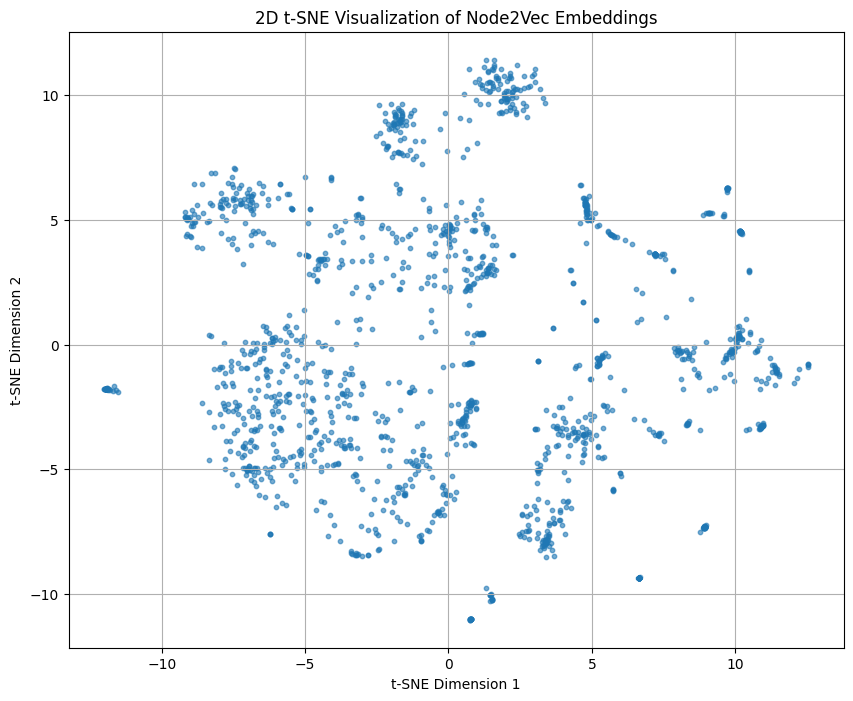

In [ ]:
from sklearn.manifold import TSNE

# Extract embeddings into a NumPy array, maintaining order of node IDs
node_ids = list(embeddings.keys())
embedding_list = [embeddings[node_id] for node_id in node_ids]
embeddings_array = np.array(embedding_list)

# Instantiate TSNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Using default perplexity and n_iter as a starting point

# Apply t-SNE dimensionality reduction
embeddings_2d = tsne.fit_transform(embeddings_array)


plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.6)
plt.title("2D t-SNE Visualization of Node2Vec Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

In [27]:
#cCalculate the degree of each node
degree_dict = dict(G.degree())
degrees = np.array(list(degree_dict.values()))

# Calculate the average shortest path length (for the largest connected component)
# Check if the graph is connected, if not, use the largest connected component
if nx.is_connected(G):
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    print(f"Average Shortest Path Length: {avg_shortest_path_length:.4f}")
else:
    print("Graph is not connected. Calculating average shortest path length for the largest connected component.")
    # Get the largest connected component
    largest_component_nodes = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_component_nodes)
    # Ensure the largest component has more than one node to calculate path length
    if G_lcc.number_of_nodes() > 1:
         avg_shortest_path_length = nx.average_shortest_path_length(G_lcc)
         print(f"Average Shortest Path Length (Largest Connected Component): {avg_shortest_path_length:.4f}")
    else:
         print("Largest connected component has only one node, cannot calculate average shortest path length.")


Graph is not connected. Calculating average shortest path length for the largest connected component.
Average Shortest Path Length (Largest Connected Component): 4.9832


In [ ]:
def edge_features(u, v, emb_dict):
    return np.concatenate([emb_dict[u], emb_dict[v]])

X = np.array([edge_features(u, v, embeddings) for u, v in X_edges])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
mlp = Sequential([
    Input(shape=(128,)),  # 64 + 64
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
mlp.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = mlp.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7862 - loss: 0.4634 - val_accuracy: 0.9230 - val_loss: 0.2197
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9252 - loss: 0.2079 - val_accuracy: 0.9328 - val_loss: 0.1875
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9385 - loss: 0.1702 - val_accuracy: 0.9348 - val_loss: 0.1794
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9455 - loss: 0.1479 - val_accuracy: 0.9419 - val_loss: 0.1635
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9541 - loss: 0.1305 - val_accuracy: 0.9414 - val_loss: 0.1657
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9574 - loss: 0.1185 - val_accuracy: 0.9443 - val_loss: 0.1579
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9621 - loss: 0.1060 - val_accuracy: 0.9471 - val_loss: 0.1504
Epoch 8/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9654 - loss: 0.0978 - val_accuracy: 0.

In [34]:
# Evaluate the model and get metrics for research paper
loss, accuracy = mlp.evaluate(X_test, y_test, verbose=0)
y_pred_prob = mlp.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32")

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Loss: 0.1660
Test Accuracy: 0.9483

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      2846
         1.0       0.95      0.94      0.95      2845

    accuracy                           0.95      5691
   macro avg       0.95      0.95      0.95      5691
weighted avg       0.95      0.95      0.95      5691



In [ ]:
# Simple - Friend recommendation
# Predict missing edges
def recommend_friends(node, G, emb_dict, model, top_k=5):
    scores = []
    for target in G.nodes():
        if node != target and not G.has_edge(node, target):
            feat = edge_features(node, target, emb_dict).reshape(1, -1)
            prob = model.predict(feat)[0][0]
            scores.append((target, prob))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:top_k]

# Example: recommend friends for node 0
recommendations = recommend_friends(0, G, embeddings, mlp, top_k=5)
print("Top 5 friend recommendations for node 0:")
for node_id, score in recommendations:
    print(f"Node {node_id} -> score: {score:.4f}")

Optimize friend recommendation \
ANNOY algorithm

In [ ]:
!pip install -q annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 40.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [31]:
# annoy setup
from annoy import AnnoyIndex
import time

# Get the dimension of the embeddings
embedding_dim = list(embeddings.values())[0].shape[0]
# Create an Annoy index
# n_trees: number of trees in the index. More trees give higher precision
# at the cost of larger index size and slower build time.
annoy_index = AnnoyIndex(embedding_dim, 'euclidean')
# Add the node embeddings to the index
node_ids = list(embeddings.keys())
for i, node_id in enumerate(node_ids):
    annoy_index.add_item(node_id, embeddings[node_id])
# Build the index
# n_jobs: number of threads to use for building the index. -1 uses all available CPU cores.
annoy_index.build(50, n_jobs=-1)

In [33]:
def recommend_friends_optimized(node_id, G, annoy_index, embeddings, top_k=5):
    """
    Recommends friends for a given node using an optimized approach with Annoy.

    Args:
        node_id: The ID of the node for which to recommend friends.
        G: The NetworkX graph.
        annoy_index: The Annoy index built on node embeddings.
        embeddings: A dictionary mapping node IDs to their embeddings.
        top_k: The number of recommendations to return.

    Returns:
        A list of top_k recommended node IDs.
    """
    existing_friends = set(G.neighbors(node_id)) | {node_id}

    # Get more neighbors than top_k to filter out existing friends
    # A buffer of top_k itself is a reasonable starting point
    n_neighbors_to_fetch = top_k * 2

    # Get the raw nearest neighbors from Annoy
    nearest_neighbors_raw = annoy_index.get_nns_by_item(node_id, n_neighbors_to_fetch, include_distances=False)

    recommended_friends = []
    # Filter out existing friends and the node itself
    for neighbor_id in nearest_neighbors_raw:
        if neighbor_id not in existing_friends:
            recommended_friends.append(neighbor_id)
        if len(recommended_friends) >= top_k:
            break

    return recommended_friends

# Example: recommend friends for node 0 using the optimized function
start_time = time.time()
recommendations_optimized = recommend_friends_optimized(0, G, annoy_index, embeddings, top_k=5)
end_time = time.time()
print(f"\nOptimized recommendation time: {end_time - start_time:.4f} seconds")

print("\nTop 5 friend recommendations for node 0 (optimized):")
for node_id in recommendations_optimized:
    print(f"Node {node_id}")


Optimized recommendation time: 0.0008 seconds

Top 5 friend recommendations for node 0 (optimized):
Node 1297
Node 58
Node 1684
Node 1450
Node 1140


In [ ]:
# 1. Define the original friend recommendation function from the previous successful execution.
def recommend_friends_original(node, G, emb_dict, model, top_k=5):
    """
    Recommends friends for a given node using the original approach (iterating through all non-connected nodes).

    Args:
        node: The ID of the node for which to recommend friends.
        G: The NetworkX graph.
        emb_dict: A dictionary mapping node IDs to their embeddings.
        model: The trained Keras model for edge prediction.
        top_k: The number of recommendations to return.

    Returns:
        A list of top_k recommended node IDs.
    """
    scores = []
    for target in G.nodes():
        if node != target and not G.has_edge(node, target):
            # Ensure both nodes have embeddings before calculating features
            if node in emb_dict and target in emb_dict:
                feat = edge_features(node, target, emb_dict).reshape(1, -1)
                prob = model.predict(feat, verbose=0)[0][0]
                scores.append((target, prob))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return [node_id for node_id, score in scores[:top_k]]

comparision of original vs optimised algot


In [ ]:
# 2. Select a node for which to compare recommendation performance.
node_to_compare = 0
top_k_value = 5

# 3. Measure the execution time of the original recommend_friends function.
start_time_original = time.time()
recommendations_original = recommend_friends_original(node_to_compare, G, embeddings, mlp, top_k=top_k_value)
end_time_original = time.time()
time_original = end_time_original - start_time_original

# 4. Measure the execution time of the optimized recommend_friends_optimized function.
# The optimized function was defined and tested in the previous step.
start_time_optimized = time.time()
recommendations_optimized = recommend_friends_optimized(node_to_compare, G, annoy_index, embeddings, top_k=top_k_value)
end_time_optimized = time.time()
time_optimized = end_time_optimized - start_time_optimized

# 5. Print the execution times for both functions.
print(f"Execution time of original recommendation function for node {node_to_compare}: {time_original:.4f} seconds")
print(f"Execution time of optimized recommendation function for node {node_to_compare}: {time_optimized:.4f} seconds")

# Print recommended nodes to verify they are the same (or similar)
print("\nRecommended friends (Original):", recommendations_original)
print("Recommended friends (Optimized):", recommendations_optimized)

# 6. Briefly describe the observed performance difference based on the printed times.
print("\nObserved Performance Difference:")
if time_optimized < time_original:
    print(f"The optimized function is significantly faster than the original function.")
else:
    print(f"The original function is faster than or similar in performance to the optimized function.")

Execution time of original recommendation function for node 0: 91.3630 seconds
Execution time of optimized recommendation function for node 0: 0.0002 seconds

Recommended friends (Original): [1297, 107, 58, 189, 217]
Recommended friends (Optimized): [1297, 107, 189, 217, 64]

Observed Performance Difference:
The optimized function is significantly faster than the original function.
